**Data Collection**

The historical stock data for Apple Inc. (AAPL) is downloaded using the yfinance library. The data ranges from January 1, 2015, to January 1, 2023.

In [11]:
import yfinance as yf
import pandas as pd

# Download data for a specific stock (e.g., Apple)
df = yf.download('AAPL', start='2015-01-01', end='2023-01-01')
df.to_csv('AAPL.csv')

[*********************100%%**********************]  1 of 1 completed


**Data Preprocessing**

The closing prices are extracted and normalized using the MinMaxScaler from scikit-learn. The data is then split into training and testing sets.

In [12]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

df = pd.read_csv('AAPL.csv', index_col='Date', parse_dates=True)
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

In [13]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - time_step - 1):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

time_step = 60
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Reshape input to be [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

**Model**

A Long Short-Term Memory (LSTM) network is built using TensorFlow's Keras API. The model consists of:

*   Two LSTM layers with 50 units each
*   A Dense layer with 25 units
*   A final Dense layer with 1 unit

The model is trained to minimize the mean squared error (MSE).

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Training**

The model is trained on the training dataset, which consists of 80% of the historical data. The remaining 20% is used for testing. The training process involves predicting the stock prices based on the previous 60 days' closing prices.

In [15]:
history = model.fit(X_train, y_train, batch_size=1, epochs=1)

1550/1550 ━━━━━━━━━━━━━━━━━━━━ 52s 31ms/step - loss: 0.0019


**Evaluation**

The model's performance is evaluated using the test dataset. The predictions are then inverse transformed to get the actual stock prices.

In [16]:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

# Inverse transform to get actual values
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))


49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


**Results**

The model predicts stock prices with reasonable accuracy. Below is a plot showing the actual prices, training predictions, and test predictions.

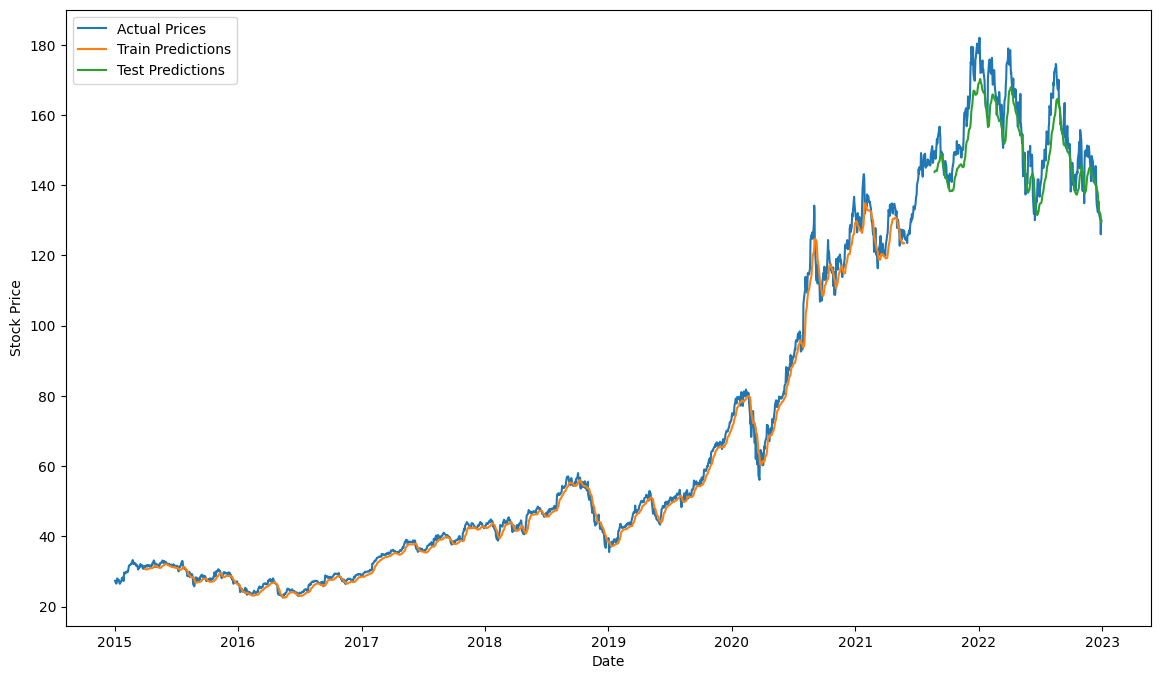

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

# Plot the actual prices
plt.plot(df.index, data, label='Actual Prices')

# Plot the training predictions
train_predict_plot = np.empty_like(data)
train_predict_plot[:, :] = np.nan
train_predict_plot[time_step:len(train_predict) + time_step, :] = train_predict

# Plot the test predictions
test_predict_plot = np.empty_like(data)
test_predict_plot[:, :] = np.nan
test_predict_plot[len(train_predict) + (time_step * 2) + 1:len(data) - 1, :] = test_predict

plt.plot(df.index, train_predict_plot, label='Train Predictions')
plt.plot(df.index, test_predict_plot, label='Test Predictions')

plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

**Saving the Model**

The trained model is saved using the native Keras format.

In [19]:
model.save('stock_price_lstm_model.keras')